## Overview

Accurate prediction of stock market asset is a significant and challenging task due to complicated nature of the financial stock markets. Considering the increasing availability and affordability of powerful computational engines, deep learning methods of prediction have proved its efficiency in finance.

## Business Understanding

A time series regression model using NN or other advanced techniques is built to predict the stock market. Stock market prediction aims to determine the future movement of the stock value of a financial exchange. This project is helpful for Stock investors and investment banks to have a better understanding in developing economical Strategy and in making financial decisions.

### Import Packages

In [1]:
import twint

import nest_asyncio
nest_asyncio.apply()

import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
#nltk.download('vader_lexicon')

## Twint

In [2]:
%%capture
# Configuring Twint to search for the subject in the first specified city
c = twint.Config()

# The amount of tweets to return sorted by most recent
c.Limit = 1000

# Input parameters
c.Search = "$AAPL"

# Removing retweets
c.Filter_retweets = True

# No pictures or video
c.Media = False

# English only
c.Lang ='en'

# Excluding tweets with links
c.Links ='exclude'

# Making the results pandas friendly
c.Pandas = True

twint.run.Search(c)

# Assigning the DF
df = twint.storage.panda.Tweets_df

In [3]:
df.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1406093429218684936,1406093429218684936,1.624074e+12,2021-06-18 23:36:12,-0400,,TEST IGNORE THIS: $AAPL $BA $DIS $NIO $NVDA $...,et,[],"[aapl, ba, dis, nio, nvda, sbux, snap, spr, sq...",...,,,,,,[],,,,
1,1406085014681538568,1406085014681538568,1.624072e+12,2021-06-18 23:02:45,-0400,,#Apple $AAPL was the indicator today for $SPY...,en,[apple],"[aapl, spy]",...,,,,,,[],,,,
2,1406077901527785473,1405994077011824644,1.624070e+12,2021-06-18 22:34:30,-0400,,@TheAlphaThought Y do ppl keep saying $aapl …i...,en,[],[aapl],...,,,,,,"[{'screen_name': 'TheAlphaThought', 'name': 'T...",,,,
3,1406077066022461441,1405899196142698505,1.624070e+12,2021-06-18 22:31:10,-0400,,@jmmantel @Invending_ @ARKInvest @21Shares_ Wh...,en,[],"[aapl, msft]",...,,,,,,"[{'screen_name': 'jmmantel', 'name': 'John Mar...",,,,
4,1406072023500066823,1406072023500066823,1.624069e+12,2021-06-18 22:11:08,-0400,,Peace and Blessing! Today's Most Traded Opti...,en,[],"[aapl, tsla, amc, amc, tsla, aapl, amc, amzn, ...",...,,,,,,[],,,,


In [4]:
def sentiment_class(score):
    """
    Labels each tweet based on its sentiment score
    """
    if score > 0: score = "Positive"
    elif score < 0: score ='Negative'
    else: score = 'Neutral'
        
    return score

In [5]:
# Instantiating the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Grabbing the sentiment scores and assigning them to a new column
df['sentiment'] = [sid.polarity_scores(df.tweet.iloc[i])['compound'] for i in range(len(df))]

# Labeling the tweets in a new column
df['feel'] = df.sentiment.apply(sentiment_class)

In [6]:
df.feel.value_counts()

Positive    439
Neutral     415
Negative    146
Name: feel, dtype: int64

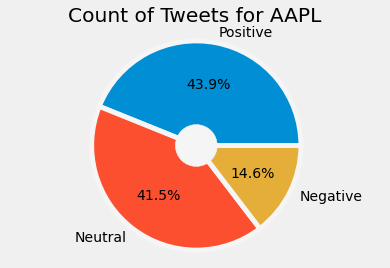

In [8]:
plt.style.use('fivethirtyeight')
#plt.rcParams['font.size'] = 30
fig, ax = plt.subplots()

ax.pie(list(df.feel.value_counts()), 
       labels=df.feel.value_counts().index, 
       autopct='%1.1f%%',
       wedgeprops = { 'linewidth': 5, 'edgecolor': 'whitesmoke' })

circle = plt.Circle((0,0), 0.2, color='whitesmoke')
fig = plt.gcf()
fig.gca().add_artist(circle)

ax.set_title(f"Count of Tweets for AAPL")
ax.axis('equal')
#plt.savefig('images/count.jpeg', format='jpeg')

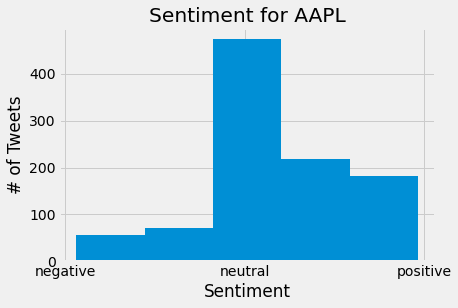

In [9]:
fig, ax = plt.subplots()

# Plotting the sentiment scores
ax.hist(df['sentiment'], bins=5)

plt.title(f"Sentiment for {'AAPL'}")
ax.set_xticks([-1,0,1])
ax.set_xticklabels(['negative', 'neutral', 'positive'])
plt.xlabel("Sentiment")
plt.ylabel("# of Tweets")
#plt.savefig('images/sentiment.jpeg', format='jpeg')

In [10]:
def twint_to_pandas(columns):
    return twint.output.panda.Tweets_df[columns]

In [11]:
df_pd = twint_to_pandas(["date", "username", "tweet", "hashtags", "nlikes"])

In [12]:
df_pd.head()

,date,username,tweet,hashtags,nlikes
0,2021-06-18 23:36:12,matthewesp,TEST IGNORE THIS: $AAPL $BA $DIS $NIO $NVDA $...,[],17
1,2021-06-18 23:02:45,FirasMsc,#Apple $AAPL was the indicator today for $SPY...,[apple],1
2,2021-06-18 22:34:30,starks2765,@TheAlphaThought Y do ppl keep saying $aapl …i...,[],1
3,2021-06-18 22:31:10,HeroDividend,@jmmantel @Invending_ @ARKInvest @21Shares_ Wh...,[],0
4,2021-06-18 22:11:08,aamirismail22,Peace and Blessing! Today's Most Traded Opti...,[],1


### Analyze sentiment of tweets

In [13]:
from textblob import TextBlob
from IPython.display import Markdown, display

In [14]:
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [15]:
for tweet in df_pd.tweet[:10]:
    print(tweet)
    analysis = TextBlob(tweet)
    print(analysis.sentiment)
    if analysis.sentiment[0] > 0:
        printmd('Positive', color = "green")
    elif analysis.sentiment[0] < 0:
        printmd('Negative', color = "red")
    else:
        printmd("Neutral", color = "grey")
        print("")

TEST IGNORE THIS:  $AAPL $BA $DIS $NIO $NVDA $SBUX $SNAP $SPR $SQ $TSLA $V
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


#Apple $AAPL  was the indicator today for $SPY DROP
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


@TheAlphaThought Y do ppl keep saying $aapl …its dividend it’s weak
Sentiment(polarity=-0.375, subjectivity=0.625)


<span style='color:red'>Negative</span>

@jmmantel @Invending_ @ARKInvest @21Shares_ Why don’t you like $AAPL or $MSFT
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>


Peace and Blessing!   Today's Most Traded Options  $AAPL 25 June $135 Call $TSLA June $620 Call $AMC June $60 Put $AMC June $60 Call $TSLA June $625 Call $AAPL June $131 Put $AMC July $20 Put $AMZN June $3500 Call $TSLA June $620 Put $EDU July $10 Call $AMC 25 June $145 Call
Sentiment(polarity=0.5, subjectivity=0.5)


<span style='color:green'>Positive</span>

@WOLF_Financial @BusinessFamous $AAPL. Tim Cook has done amazing. $FB as well.
Sentiment(polarity=0.6000000000000001, subjectivity=0.9)


<span style='color:green'>Positive</span>

@jimcramer Why the love for clearly overvalued tech? In 2008 you used to be a pragmatic investor who cared about free cash flow &amp; profits. Clearly the ONLY sector with any potential for fundamentally based price appreciation is oil &amp; gas. $OXY is a buy over $TSLA $AAPL or $FB
Sentiment(polarity=0.18333333333333335, subjectivity=0.6944444444444443)


<span style='color:green'>Positive</span>

This guy posting daily charts for altcoins. Follow him @kucoincoinpump   $ETC $AMPH $MTV $HORD $AION $INSW $ALGO $HPMM $PFSW $CNTY $SWAP $CAPP #BNB $ORAI $ENB $aapl $CTSI $POKE $CELR $PIVX $VAI $EPZM $HOT $XMR
Sentiment(polarity=0.125, subjectivity=0.42500000000000004)


<span style='color:green'>Positive</span>

18-Jun 短期口座PF Tech大 $AAPL $GOOG $FB $MSFT Tech小 $ADBE $CRWD $DOCU $FVRR $OKTA $TTD $VEEV $ZM 半導体 $LSCC $NVDA $SMH IPO $AGC $HOL $MQ $NSH $SFTW $U $VACQ $QS $ULCC Old $BA $CCL $DIS $KO $LHX $LMT $NCLH $VTI $WYNN 医療 $AMGN $BIIB $BMY $BNTX $GILD $MRNA $RPRX $TDOC (続く)
Sentiment(polarity=0.1, subjectivity=0.2)


<span style='color:green'>Positive</span>

watchlist for today: $PINS - $WKHS - $AAPL - $ORPH - $TRCH &amp;’ $DKNG 🚀
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>Neutral</span>

## Add sentiments to dataframe

In [16]:
from pyspark.sql.functions import udf

In [17]:
def apply_blob(sentence):
    temp = TextBlob(sentence).sentiment[0]
    if temp == 0.0: return 0.0 # Neutral
    elif temp > 0.0: return 1.0 # Positive
    else: return 2.0 # Negative

In [18]:
sentiment = udf(apply_blob)

df_pd["sentiment"] = df_pd.tweet.map(apply_blob)

<ipython-input-18-e9d9462ca1e8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd["sentiment"] = df_pd.tweet.map(apply_blob)


In [19]:
df_pd.head()

,date,username,tweet,hashtags,nlikes,sentiment
0,2021-06-18 23:36:12,matthewesp,TEST IGNORE THIS: $AAPL $BA $DIS $NIO $NVDA $...,[],17,0.0
1,2021-06-18 23:02:45,FirasMsc,#Apple $AAPL was the indicator today for $SPY...,[apple],1,0.0
2,2021-06-18 22:34:30,starks2765,@TheAlphaThought Y do ppl keep saying $aapl …i...,[],1,2.0
3,2021-06-18 22:31:10,HeroDividend,@jmmantel @Invending_ @ARKInvest @21Shares_ Wh...,[],0,0.0
4,2021-06-18 22:11:08,aamirismail22,Peace and Blessing! Today's Most Traded Opti...,[],1,1.0


<AxesSubplot:xlabel='sentiment', ylabel='Count'>

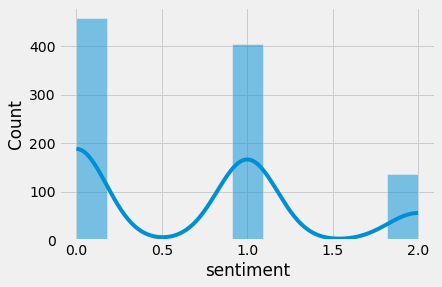

In [20]:
# Lets see the distribution of the sentiments

sns.histplot(df_pd['sentiment'], kde=True)

## Word Clouds

In [21]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import string

In [22]:
## setting stopwords and punctuations
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)

sw_set = set(sw_list)

In [23]:
# we can define a function that removes stopwords 
def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]
    return stopwords_removed 

In [24]:
pros = list(map(process_article, df_pd.tweet))

flat = [item for sublist in pros for item in sublist]
freq = FreqDist(flat)

counts = [x[1] for x in freq.most_common(25)]
words = [x[0] for x in freq.most_common(25)]

dictionary = dict(zip(words, counts))

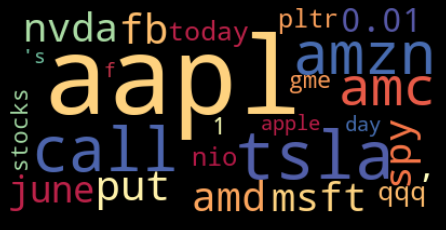

In [25]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(dictionary)

# Display the generated image w/ matplotlib:
plt.figure(facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

In [26]:
text = df_pd.tweet.values
wordcloud = WordCloud(background_color = 'black', stopwords=sw_set).generate(str(text))

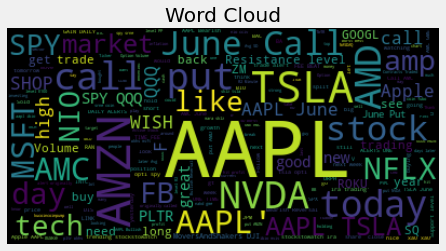

In [27]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Word Cloud")
#plt.savefig('images/word.jpeg', format='jpeg')